# EDA on the Open Food Facts dataset

The notebook analyses the dataset by focussing on the task of extracting nutrition information using images.

As the size of the dataset is large and therefore unable to into memory of my laptop, we will randomly select rows from the entire dataset.
* Count the total number of rows in the dataset.
* I have chosen 5000 to be the sample size.
* The dataset is read in chunks of 10,000 rows.
* nb_chunks = total_rows// chunk_size + 1
* nb_samples_per_chunk = nb_samples // nb_chunks + 1

For reproducibility, I set the seed of the numpy random generator

In [24]:
import pandas as pd
import numpy as np
import gzip
import chardet
from tqdm import tqdm
from pathlib import Path
from ydata_profiling import ProfileReport

FILEPATH = Path('../data/food.csv')
IMAGE_DOWNLOAD_PATH = Path('../data/images')
SAMPLE_SIZE = 5000
CHUNK_SIZE = 10000
SEED = 42

In [ ]:
def get_rows_encoding(filepath: Path|str) -> tuple[int, str]:
    """"
    Get total rows and encoding of a gzipped CSV file
    Args:
        filepath: Path to the gzipped CSV file
    Returns:
        Tuple of total rows and encoding"""
    
    # Detect file encoding first
    with gzip.open(filepath, 'rb') as f:
        rawdata = f.read(10000)  # Read a small portion to detect encoding
        detected_encoding = chardet.detect(rawdata)['encoding']

    # Count total rows
    with gzip.open(filepath, 'rt', encoding=detected_encoding, errors='replace') as f:
        total_rows = sum(1 for _ in f) - 1  # Subtract header
    return total_rows, detected_encoding

total_rows, detected_encoding = get_rows_encoding(FILEPATH)
print(f'Total rows: {total_rows}, Encoding: {detected_encoding}')

Total rows: 3649876, Encoding: utf-8


In [ ]:
def create_sampled_ds(filepath: Path, sample_size: int, chunk_size: int, seed: int) -> pd.DataFrame:
    """
    Create a sampled dataset from a gzipped CSV file
    Args:
        filepath: Path to the gzipped CSV file
        sample_size: Number of samples to create
        chunk_size: Number of rows to read per chunk
        seed: Random seed for reproducibility
    """
    np.random.seed(seed)

    nb_chunks = total_rows // chunk_size + 1
    nb_samples_per_chunk = sample_size // nb_chunks + 1

    print(f"Number of chunks: {nb_chunks}")
    print(f"Samples per chunk: {nb_samples_per_chunk}")

    df_sample = pd.DataFrame()
    df_iter = pd.read_csv(filepath, compression="gzip", encoding=detected_encoding, sep='\t', 
                          chunksize=chunk_size, on_bad_lines='skip', low_memory=False)

    for _ in tqdm(range(nb_chunks), desc="Sampling dataset"):
        df = next(df_iter)

        if len(df) < nb_samples_per_chunk:
            break

        random_rows = np.random.choice(df.index, size=nb_samples_per_chunk, replace=False)
        df_sample = pd.concat([df_sample, df.iloc[random_rows - df.index.start]])

        if len(df_sample) >= sample_size:
            break

    return df_sample

df_sample = create_sampled_ds(FILEPATH, SAMPLE_SIZE, CHUNK_SIZE, SEED)

Number of chunks: 365
Samples per chunk: 14


Sampling dataset:  98%|█████████▊| 357/365 [01:41<00:02,  3.53it/s]


## Columns

We will now look into the different columns present in the dataset

In [7]:
columns = df_sample.columns

print(f"Number of columns: {len(columns)}")
print(f"Columns: {sorted(columns)}")

Number of columns: 206
Columns: ['abbreviated_product_name', 'acidity_100g', 'added-salt_100g', 'added-sugars_100g', 'additives', 'additives_en', 'additives_n', 'additives_tags', 'alcohol_100g', 'allergens', 'allergens_en', 'alpha-linolenic-acid_100g', 'arachidic-acid_100g', 'arachidonic-acid_100g', 'behenic-acid_100g', 'beta-carotene_100g', 'beta-glucan_100g', 'bicarbonate_100g', 'biotin_100g', 'brand_owner', 'brands', 'brands_tags', 'butyric-acid_100g', 'caffeine_100g', 'calcium_100g', 'capric-acid_100g', 'caproic-acid_100g', 'caprylic-acid_100g', 'carbohydrates_100g', 'carbon-footprint-from-meat-or-fish_100g', 'carbon-footprint_100g', 'carnitine_100g', 'casein_100g', 'categories', 'categories_en', 'categories_tags', 'cerotic-acid_100g', 'chloride_100g', 'chlorophyl_100g', 'cholesterol_100g', 'choline_100g', 'chromium_100g', 'cities', 'cities_tags', 'cocoa_100g', 'code', 'collagen-meat-protein-ratio_100g', 'completeness', 'copper_100g', 'countries', 'countries_en', 'countries_tags', 

In [8]:
from enum import Enum

# Define an Enum for columns
class DatasetColumns(Enum):
    """Enum for dataset columns to avoid using string literals."""
    __slots__ = ()  # Prevent instance attributes for efficiency

    @classmethod
    def create(cls):
        return {col.upper(): col for col in columns}  # Convert to uppercase for consistency
    
ds_cols = Enum('DatasetColumns', DatasetColumns.create())


## Missing Values

We will now take a look into the missing values that are present in the dataset.

In [9]:

# Checking for missing values
missing_values = df_sample.isnull().sum().sort_values(ascending=False)

missing = missing_values[missing_values > 0]
no_missing = missing_values[missing_values == 0]
all_missing = missing_values[missing_values == len(df_sample)]

print(f"Number of columns with no missing values:{len(no_missing)}")
print(no_missing.keys().to_list())

print(f"Number of columns with all missing values: {len(all_missing)}")
print(all_missing.keys().to_list()) 

print(f"Number of columns with missing values: {len(missing)}")


Number of columns with no missing values:10
['states_tags', 'states', 'last_modified_t', 'created_datetime', 'states_en', 'creator', 'url', 'code', 'created_t', 'last_modified_datetime']
Number of columns with all missing values: 55
['cities', 'allergens_en', 'additives', 'palmitic-acid_100g', 'stearic-acid_100g', 'arachidic-acid_100g', 'behenic-acid_100g', 'lignoceric-acid_100g', 'montanic-acid_100g', 'melissic-acid_100g', 'omega-9-fat_100g', 'unsaturated-fat_100g', 'butyric-acid_100g', 'energy-from-fat_100g', 'insoluble-fiber_100g', 'linoleic-acid_100g', 'mead-acid_100g', 'arachidonic-acid_100g', 'elaidic-acid_100g', 'oleic-acid_100g', 'dihomo-gamma-linolenic-acid_100g', 'gondoic-acid_100g', 'erucic-acid_100g', 'nervonic-acid_100g', 'fructose_100g', 'erythritol_100g', 'added-salt_100g', 'casein_100g', 'serum-proteins_100g', 'nucleotides_100g', 'chlorophyl_100g', 'inositol_100g', 'glycemic-index_100g', 'water-hardness_100g', 'beta-glucan_100g', 'beta-carotene_100g', 'silica_100g', 'ch

## Drop columns with all missing values

Though this is based on small subset of the dataset, we will drop columns that have all missing values. Ideally, it would be better to try on a larger sampled subset to draw better conclusions.

In [12]:
filtered_cols = set(columns) - set(all_missing.keys().to_list())

df_sample = df_sample[list(filtered_cols)]

print(f"Number of columns after removing empty columns: {len(df_sample.columns)}")

Number of columns after removing empty columns: 151


## IMAGE NUTRITION (RELEVANT DATA)
Since we are interested in extracting the nutrition information from product images, we will first look at the `image_nutrition_url`. Drop the rows that have `nan` values.

In [13]:
print(f"Number of missing values for {ds_cols.IMAGE_NUTRITION_URL.value}: {missing_values[ds_cols.IMAGE_NUTRITION_URL.value]}")
df_sample = df_sample.dropna(subset=[ds_cols.IMAGE_NUTRITION_URL.value])
nutr_urls= df_sample.image_nutrition_url.to_list()
nutr_urls[:10]

Number of missing values for image_nutrition_url: 2368


['https://images.openfoodfacts.org/images/products/000/093/579/8254/nutrition_it.5.400.jpg',
 'https://images.openfoodfacts.org/images/products/000/094/411/2453/nutrition_it.5.400.jpg',
 'https://images.openfoodfacts.org/images/products/000/068/480/0071/nutrition_fr.5.400.jpg',
 'https://images.openfoodfacts.org/images/products/000/000/000/0501/nutrition_en.6.400.jpg',
 'https://images.openfoodfacts.org/images/products/000/100/211/2784/nutrition_fr.10.400.jpg',
 'https://images.openfoodfacts.org/images/products/000/429/057/7593/nutrition_en.5.400.jpg',
 'https://images.openfoodfacts.org/images/products/000/201/595/0045/nutrition_en.5.400.jpg',
 'https://images.openfoodfacts.org/images/products/000/534/231/3189/nutrition_en.5.400.jpg',
 'https://images.openfoodfacts.org/images/products/000/000/006/2237/nutrition_en.18.400.jpg',
 'https://images.openfoodfacts.org/images/products/000/000/010/4975/nutrition_en.15.400.jpg']

### Analysing different languages
We observe that they are in different languages. For example the filename `nutrition_fr..jpg` is in French, `nutrition_en..jpg` is in English and so on. Let's plot a histogram on the different languages present in the nutrition label.

In [14]:
languages = []

for url in nutr_urls:
    try:
        lang = url.split('/')[-1].split('.')[0].split('_')[1] 
        languages.append(lang)
    except IndexError:
        print(f"Skipping URL {url}")


Skipping URL https://images.openfoodfacts.org/images/products/541/040/101/3014/nutrition.8.400.jpg


## Language Distribution in Nutrition Image URLs

- We analyze the distribution of languages in nutrition image URLs.
- This helps us understand whether certain languages dominate the dataset.

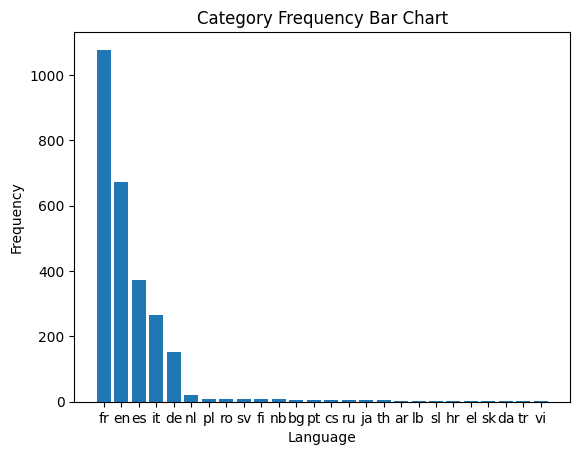

In [15]:
import matplotlib.pyplot as plt
from collections import Counter

%matplotlib inline

# Count occurrences of each language
language_counts = Counter(languages)

sorted_languages = sorted(language_counts.items(), key=lambda x: x[1], reverse=True)
langs, counts = zip(*sorted_languages)

# Plot bar chart
plt.bar(langs, counts)

# Labels and title
plt.xlabel('Language')
plt.ylabel('Frequency')
plt.title('Category Frequency Bar Chart')

# Show plot
plt.show()

For this particular subset of the dataset, we observe that main languages are French, English, Spanish and Italian. Ideally, we should to look bigger chunks to check if this observation holds. For limit the scope of this exercise we focus of the nutrition images that are in English.

Now let's look into the actual images to check the quality. 

In [18]:
en_image_urls = [url for url, lang in zip(nutr_urls, languages) if lang == 'en']

df_sample = df_sample[df_sample[ds_cols.IMAGE_NUTRITION_URL.value].isin(en_image_urls)]

print(f"Number of rows after only keeping images that are in English: {len(df_sample)}")

Number of rows after only keeping images that are in English: 673


## Looking at the quality of the images

100%|██████████| 10/10 [00:00<00:00, 1611.09it/s]


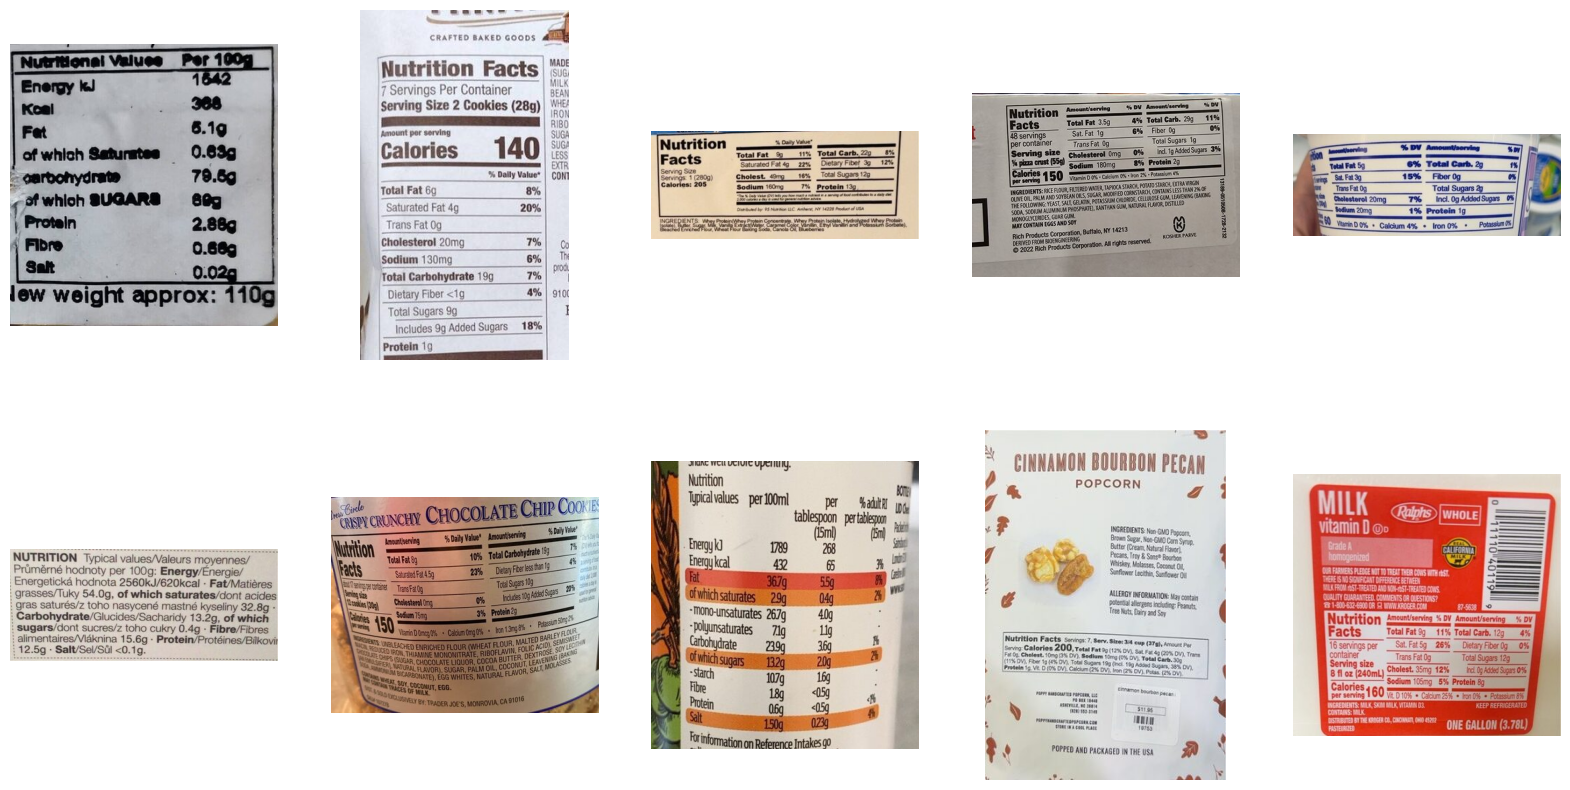

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import wget
from pathlib import Path

def download_images(urls:list[str], download_dir:Path, force:bool=False):
    download_dir.mkdir(exist_ok=True)
    for url in tqdm(urls):
        try:
            download_path = download_dir / ('_').join(url.split('/')[-5:])
            if not force and download_path.exists():
                continue
            wget.download(url, out=str(download_path))
        except Exception as e:
            print(f"Error Downloading {e} ... Skipping URL {url}")



def plot_images(urls:list[str], image_dir: Path):
    images = []
    for url in tqdm(urls):
        try:
            image_path = image_dir / ('_').join(url.split('/')[-5:])
            image = Image.open(image_path)
            images.append(image)
        except Exception as e:
            print(f"Error reading image {e} ... Skipping  {image_path}")

    # Display images
    _, axes = plt.subplots(len(images)//5 , 5, figsize=(20, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.axis('off')
    plt.show()

download_images(en_image_urls[:10], IMAGE_DOWNLOAD_PATH)
plot_images(en_image_urls[:10], IMAGE_DOWNLOAD_PATH)

The images have different orientations, resolution and quality. 
* Some of the images are not entirely focussed on the nutrition section. They would require some cropping to remove the unnecessary contents.
* Some have nutrition value in tabular format, some as paragraphs.
* Some of the images have quantities given an serving size instead of 100g. The ground-truth mentions the values per 100g therefore we will need to know the serving_size and serving_quantity.

### Serving Size and Serving quantity

Number of missing values for serving_size: 3728
Number of missing values for serving_size_unit: 3748
Number of rows after removing missing values in serving size and quantity: 193
Serving size column:
serving_size
100g                8
100.0g              5
1 Tbsp (15 ml)      4
28 g                3
8 OZA (240 ml)      3
                   ..
180g                1
2 units (25 g)      1
180 g               1
1 portion (32 g)    1
304g                1
Name: count, Length: 156, dtype: int64

Value of serving_quantity column:
serving_quantity
100.0    21
28.0     13
30.0     12
15.0     11
240.0     5
         ..
82.0      1
113.0     1
92.0      1
350.0     1
304.0     1
Name: count, Length: 89, dtype: int64


Text(0.5, 1.0, 'Serving Size Histogram')

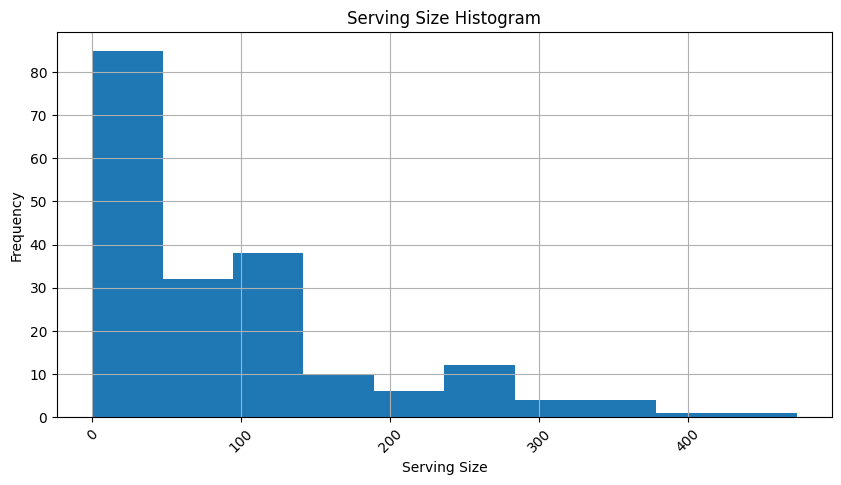

In [37]:
print(f"Number of missing values for serving_size: {missing_values[ds_cols.SERVING_SIZE.value]}")
print(f"Number of missing values for serving_size_unit: {missing_values[ds_cols.SERVING_QUANTITY.value]}")

df_sample = df_sample.dropna(subset=[ds_cols.SERVING_SIZE.value, ds_cols.SERVING_QUANTITY.value])
print(f"Number of rows after removing missing values in serving size and quantity: {len(df_sample)}")

print("Serving size column:")
print(df_sample[ds_cols.SERVING_SIZE.value].value_counts())


print("\nValue of serving_quantity column:")
print(df_sample[ds_cols.SERVING_QUANTITY.value].value_counts())

# plot histogram
df_sample[ds_cols.SERVING_QUANTITY.value].hist(bins=10, figsize=(10, 5))
plt.xticks(rotation=45)
plt.xlabel('Serving Size')
plt.ylabel('Frequency')
plt.title('Serving Size Histogram')

## Further cleaning
1. The column `data_quality_errors_tags` has bunch of tags to signifiy an error in the nutrition value. We can ignore the rows with have these tags.

In [38]:
# Remove rows with data quality errors
df_sample = df_sample[df_sample.data_quality_errors_tags.isna()]
print(f"Number of rows after removing data quality errors: {len(df_sample)}")

Number of rows after removing data quality errors: 182


## Other Relevant information
To improve of help the perhaps predict the nutrition content of cases the OCR does not accurately detect or completely miss the certain nutrient values, we can may be leverage the `nutriscore`, `nova_group`, `pnns_groups_1`, `pnns_groups_2` to help predict these missing values. I use ydata_profiling to analyse these columns

In [39]:
other_relevant = [ds_cols.NUTRISCORE_GRADE.value,
                  ds_cols.NUTRISCORE_GRADE.value, 
                  ds_cols.NOVA_GROUP.value, 
                  ds_cols.PNNS_GROUPS_1.value, 
                  ds_cols.PNNS_GROUPS_2.value,
                  ds_cols.MAIN_CATEGORY_EN.value]
df_other_relevant = df_sample[other_relevant]

profile = ProfileReport(df_other_relevant, title="Other Relevant Columns Profiling Report", minimal=True)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Nutrition Data Profiling

- We generate a **lightweight profiling report** to explore nutritional values.

In [42]:
# Finally looking at the nutrition columns
nutri_columns = [col for col in columns if '_100g' in col and col not in all_missing.keys()]

df_nutri_columns = df_sample[nutri_columns]

# Removing columns with all missing values
df_nutri_columns = df_nutri_columns.dropna(axis=1, how='all')

profile = ProfileReport(df_nutri_columns, title="Nutrition Report", minimal=True)
profile


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]